<a href="https://colab.research.google.com/github/amitthakur2013/Project_Clg_Tumor_Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary modules**

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import skimage.io
import tqdm
import os

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray 

from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import InputLayer, ZeroPadding2D, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print("All Imports Successfull!")

%matplotlib inline

All Imports Successfull!


**Importing/ Vewing/ Pre-Processing Dataset**

In [109]:
# Importing Dataset

cancerous = os.listdir('/content/brain_tumor_dataset/yes')
non_cancerous = os.listdir('/content/brain_tumor_dataset/no')

In [110]:
len(cancerous), len(non_cancerous)

(155, 98)

100%|██████████| 5/5 [00:00<00:00, 38.23it/s]


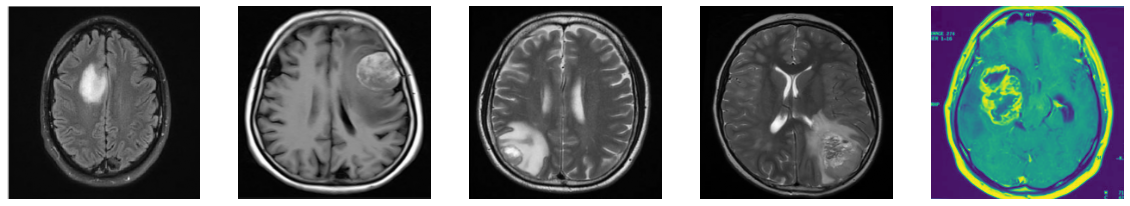

In [111]:
# Viewing Dataset - Cancerous

fig, ax=plt.subplots(nrows = 1, ncols =5, figsize = (20,20)) 

for i in tqdm(range(0,5)):
  rand = np.random.randint(len(cancerous))
  img = imread('/content/brain_tumor_dataset/yes/'+cancerous[rand])
  img = resize(img, (224,224))
  ax[i].imshow(img)
  ax[i].axis('off')

100%|██████████| 5/5 [00:00<00:00, 47.09it/s]


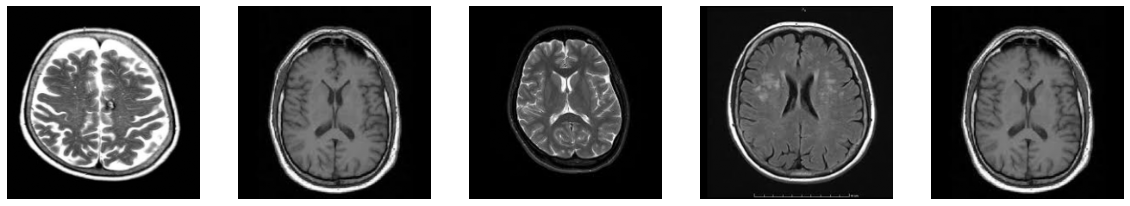

In [112]:

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(non_cancerous))
    img  = imread('/content/brain_tumor_dataset/no/' + non_cancerous[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

In [113]:
# Converting images into proper shape and storing them as  an array 

Image=[]
Label=[]

for i in tqdm(range(0, len(cancerous))):
  img=imread('/content/brain_tumor_dataset/yes/'+cancerous[i]) 
  img=resize(img, (224, 224, 3))
  Image.append(img)
  Label.append(1)

for i in tqdm(range(0,len(non_cancerous))):
  img=imread('/content/brain_tumor_dataset/no/'+non_cancerous[i])
  img=resize(img,(224, 224, 3))
  Image.append(img)
  Label.append(0)

Image=np.array(Image)
Label=np.array(Label)

100%|██████████| 98/98 [00:03<00:00, 29.81it/s]


In [114]:
# Normalizing 

Image.min(), Image.max()

(0.0, 1.0)

In [115]:
# Shuffle the data as results are appended.

Image, Label = shuffle(Image, Label, random_state = 42)

100%|██████████| 5/5 [00:00<00:00, 381.30it/s]


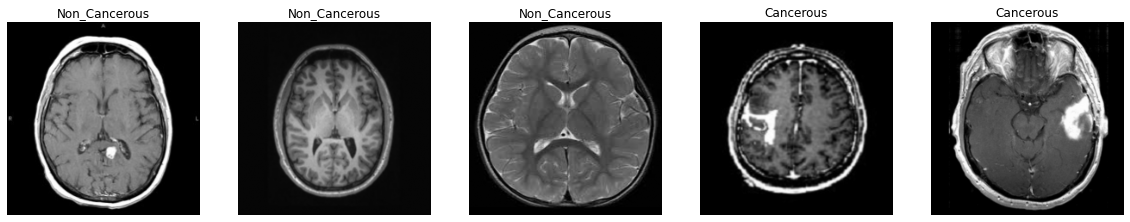

In [116]:
# Viewing Image - After Shuffle

fig,ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20, 20))

for i in tqdm(range(0,5)):
  rand=np.random.randint(len(Image))
  ax[i].imshow(Image[rand])
  ax[i].axis('off')
  a=Label[rand]
  if a==1:
    ax[i].set_title('Cancerous')
  else:
    ax[i].set_title('Non_Cancerous')

In [117]:
# Assigning Images and Label to new variable 

X = Image
y = Label

In [118]:
# Splitting Data - Training and Validation

X_train, X_val, y_train, y_val=train_test_split(X, y, test_size = 0.3, random_state = 42)


In [119]:
# Checking Shape

X_train.shape, X_val.shape

((177, 224, 224, 3), (76, 224, 224, 3))

In [120]:
# Creating augmentation object

train_datagen  = ImageDataGenerator(rescale = 1./255,
                                    width_shift_range = 0.05,
                                    height_shift_range = 0.05,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    rotation_range = 30,
                                    fill_mode = 'nearest',
                                    zoom_range = 0.2,
                                    shear_range = 0.2)

# Fitting to train data

train_datagen.fit(X_train)

**Model Building**

In [121]:
# Model Initialization

model = Sequential()

In [122]:
# Building Layers
# Input Layer 
model.add(InputLayer(input_shape = (224,224,3)))


# Adding Zero Padding
model.add(ZeroPadding2D((2,2), data_format = 'channels_last'))


# Adding Layers
model.add(Conv2D(filters = 32,  kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64,  kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))


# Adding Flatten
model.add(Flatten())


# Adding Dense-FCC
model.add(Dense(units = 128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


# Adding Output 
model.add(Dense(units = 1, activation = 'sigmoid'))

In [123]:
# Compiling Model

model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [124]:
# Defining Callbacks
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
# Model Run

model.fit(train_datagen.flow(X_train, y_train, batch_size = 32),
          validation_data = (X_val, y_val),
          epochs = 500,
          verbose = 1,
          callbacks = callback_list)

Cancerous Cell


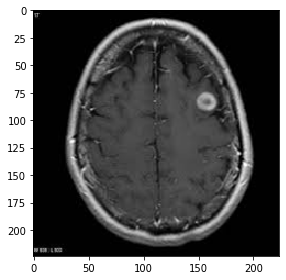

In [128]:
# Model Prediction
image = imread('/content/brain_tumor_dataset/Y53.jpg')
#image = imread('https://med.nyu.edu/sites/default/files/radiology/our-service.jpg')
image = resize(image, (224,224,3))
imshow(image)
image = np.expand_dims(image, 0)

prediction  = model.predict_classes(image)

if prediction[0][0] == 1:
    print("Cancerous Cell")
else:
    print("Non-Cancerous Cell")